In [ ]:
%pip install sktime
%pip install sktime[all_extras]
%pip install esig
%pip install utils

     |████████████████████████████████| 6.2 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 33.7 MB/s 
     |████████████████████████████████| 9.8 MB 30.1 MB/s 
     |████████████████████████████████| 14.9 MB 31.0 MB/s 
     |████████████████████████████████| 34.5 MB 11 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 wh

  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
     |████████████████████████████████| 43 kB 921 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 580 kB 49.9 MB/s 
     |████████████████████████████████| 11.2 MB 42.5 MB/s 
     |████████████████████████████████| 113 kB 46.9 MB/s 
     |████████████████████████████████| 114 kB 68.8 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 786 kB 61.7 MB/s 
     |████████████████████████████████| 9.5 MB 28.9 MB/s 
     |████████████████████████████████| 205 kB 70.7 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |███████████████████

     |████████████████████████████████| 6.9 MB 5.1 MB/s 


In [1]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)

Importar librerías básicas

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,\
                                                   mean_absolute_error, mean_squared_error

# Naive Forecast / Pronóstico Ingenuo
from sktime.forecasting.naive import NaiveForecaster

# AutoARIMA
from sktime.forecasting.arima import AutoARIMA

# AutoETS
from sktime.forecasting.ets import AutoETS

# Algoritmos de Regresión de sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/home/Carlos/.local/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/Carlos/.local/lib/python3.10/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/dataty

In [3]:
#Definición de funciones

def evaluar_modelo(test,pred):
  print('MAPE:',mean_absolute_percentage_error(test, pred, symmetric=False)) 
  print('SMAPE:',mean_absolute_percentage_error(test, pred)) #symmetric default=True
  print('MAE:',mean_absolute_error(test, pred) )
  print('RMSE:',mean_squared_error(test, pred, square_root=True) ) # square_root=True RMSE , false MSE)
  print('MSE:',mean_squared_error(test, pred, square_root=False) ) # square_root=True RMSE , false MSE)

def graficar_modelo(train,test,pred,titulo='Modelo',inicio_serie=200):
  plot_series(train[inicio_serie:], test, pred, labels=["y_train", "y_test", "y_pred"])
  plt.axhline(y=0.5, color='r', linestyle='dashed')
  plt.title(titulo)
  plt.show()



# 1. Cargar los datos de SPI o SPEI

In [15]:
def cargar_datos(archivo):
#     data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/' + archivo,  sep = ',', parse_dates=True)
    data = pd.read_csv('../datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    return data

# 2. Preprocesamiento de los datos

In [5]:
'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

## Normalizar los datos

In [6]:
'''para mejores resultados se pueden normalizar los datos: [0,1]'''
def normalizar_datos(data):
    return (data - data.min()) / ( data.max() - data.min())

# 3. Dividir Datos en Entrenamiento y prueba

In [7]:
'''Dividir el Dataset en Entrenamiento y prueba'''
def dividir_datos(serie, tamanio):
    y_train, y_test = temporal_train_test_split(serie, test_size=tamanio)
    return y_train, y_test

## Definir  el horizonte de predicción

In [8]:
'''Definir horizonte de predicción'''
def horizon_prediccion(y_test):
    return ForecastingHorizon(y_test.index, is_relative=False)  #fh=['2020-01', '2020-02'.....

# 4. Configuración del algoritmo

In [9]:
def config_algoritmo(algoritmo, estacionalidad = 12, ventana = 12, estrategia = 'mean'):
    if algoritmo=='naive': return NaiveForecaster(strategy=estrategia, sp=estacionalidad, window_length=ventana) #strategy="drift" o "last"  sp estacionalidad
    elif algoritmo=='arima': return AutoARIMA(sp=estacionalidad, suppress_warnings=True) #Cambiar sp para reducir el error
    elif algoritmo=='ets': return AutoETS(auto=True,sp=estacionalidad, n_jobs=-1) #sp=12

def config_algoritmoReg(algoritmo,ventana = 12, estrategia = 'recursive',estimadores=30, vecinos=11):
  if algoritmo=='LinearRegression':
    reg=LinearRegression()    
  elif algoritmo=='DecisionTreeRegressor': 
    reg=DecisionTreeRegressor()
  elif algoritmo=='KNeighborsRegressor':
    reg=KNeighborsRegressor(n_neighbors=vecinos)
  elif algoritmo=='RandomForestRegressor':
    reg=RandomForestRegressor(n_estimators=estimadores)
  return make_reduction(reg,strategy=estrategia, window_length=ventana)

# 5. Ajuste del Modelo

In [10]:
def ajuste(predictor, y_train):
    return predictor.fit(y_train)

# 6. Predicción del Modelo

In [11]:
def prediccion(predictor, horiz_prediccion):
    return predictor.predict(horiz_prediccion)

# 7. Evaluación del Modelo

In [12]:
def evaluacion_modelo(test,pred):
    mape = mean_absolute_percentage_error(test, pred, symmetric=False)
    smape = mean_absolute_percentage_error(test, pred) #symmetric default=True
    mae = mean_absolute_error(test, pred) 
    rmse = mean_squared_error(test, pred, square_root=True) # square_root=True RMSE , false MSE)
    mse = mean_squared_error(test, pred, square_root=False) # square_root=True RMSE , false MSE)
    return [mape, smape, mae, rmse, mse]

# MODELOS ESTADÍSTICOS DE FORECASTING (SERIES TEMPORALES)

In [25]:
'''Definir el horizonte de la prediccion'''
tam_ypred = 12

'''1. Cargar archivo'''
datos = cargar_datos('indices_spi3.csv')

'''2. Procesamiento de datos'''
datos_procesados = procesa_datos(datos)

'''-- Declara DF para almacenar los y_pred,
      extraer los nombres de las columnas,
      DF para almacenar los datos de la evaluacion'''
df_pred = pd.DataFrame(index = datos_procesados.tail(tam_ypred).index)
columnas = datos_procesados.columns
df_eval = pd.DataFrame(index = ['MAPE','SMAPE','MAE','RMSE','MSE'])

'''-- Normalizar datos'''
datos_normalizados = normalizar_datos(datos_procesados)

for i in range(30):
    
    '''-- Trabajar con una estación'''
    serie = datos_normalizados.iloc[:, i]
    
    '''3. Datos de entrenamiento y prueba'''
    y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)
    
    '''Definir el horizonte de predicción'''
    horizonte_prediccion = horizon_prediccion(y_test)
    
    '''4. Configurar algoritmo, valores ['naive', 'arima', 'ets']'''
    predictor = config_algoritmo('arima', estacionalidad = 12, ventana = 48, estrategia = 'mean')
    
    '''5. Ajuste modelo'''
    predictor = ajuste(predictor, y_train)
    
    '''6. Predicción'''
    y_pred = prediccion(predictor, horizonte_prediccion)
    
    '''7. Evaluación'''
    datos_eval = evaluacion_modelo(y_test, y_pred)
    
    '''-- Almacenar todos los y_pred y datos_eval en DFs'''
    df_pred = pd.concat([df_pred, y_pred], axis = 1)
    df_eval[i] = datos_eval

'''Cambiar el nombre de las columnas'''
df_pred.columns = ['predic_'+columna[-3:] for columna in columnas]
df_eval.columns = ['eval_'+columna[-3:] for columna in columnas]




/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a f

/home/Carlos/.local/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(4,0,0)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

In [34]:
df_pred.to_csv('../datos/predic_spi_arima_pEst.csv', index=False)
df_eval.to_csv('../datos/eval_spi_arima_pEst.csv', index=False)

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


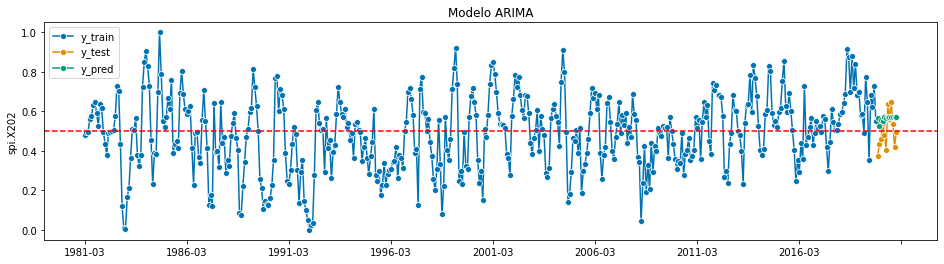

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


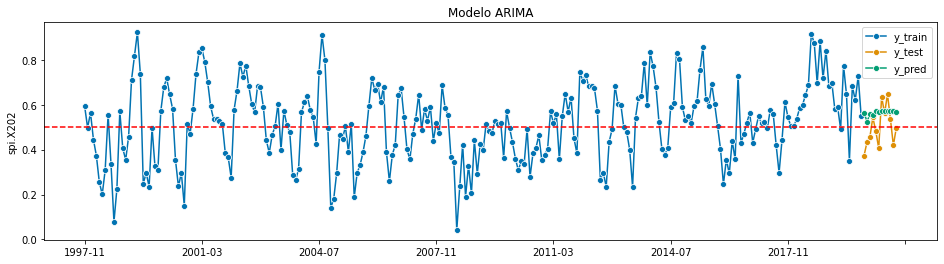

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


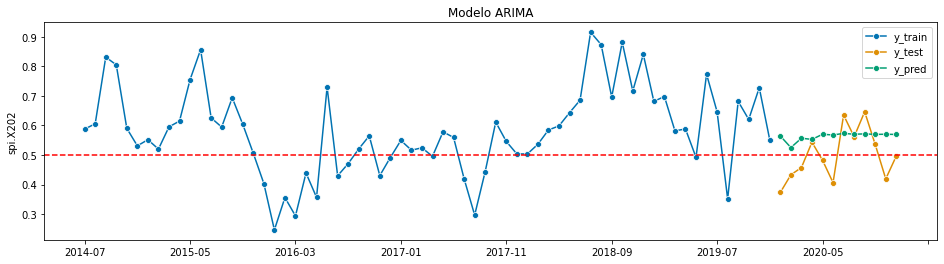

In [32]:
#La columna indica la estación de 0 a 29 para las 30 estaciones
columna = 25
train, test = dividir_datos(datos_normalizados.iloc[:, columna], tamanio = tam_ypred)

graficar_modelo(train,test,df_pred.iloc[:,columna],'Modelo ARIMA',0)
graficar_modelo(train,test,df_pred.iloc[:,columna],'Modelo ARIMA',200)
graficar_modelo(train,test,df_pred.iloc[:,columna],'Modelo ARIMA',400)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

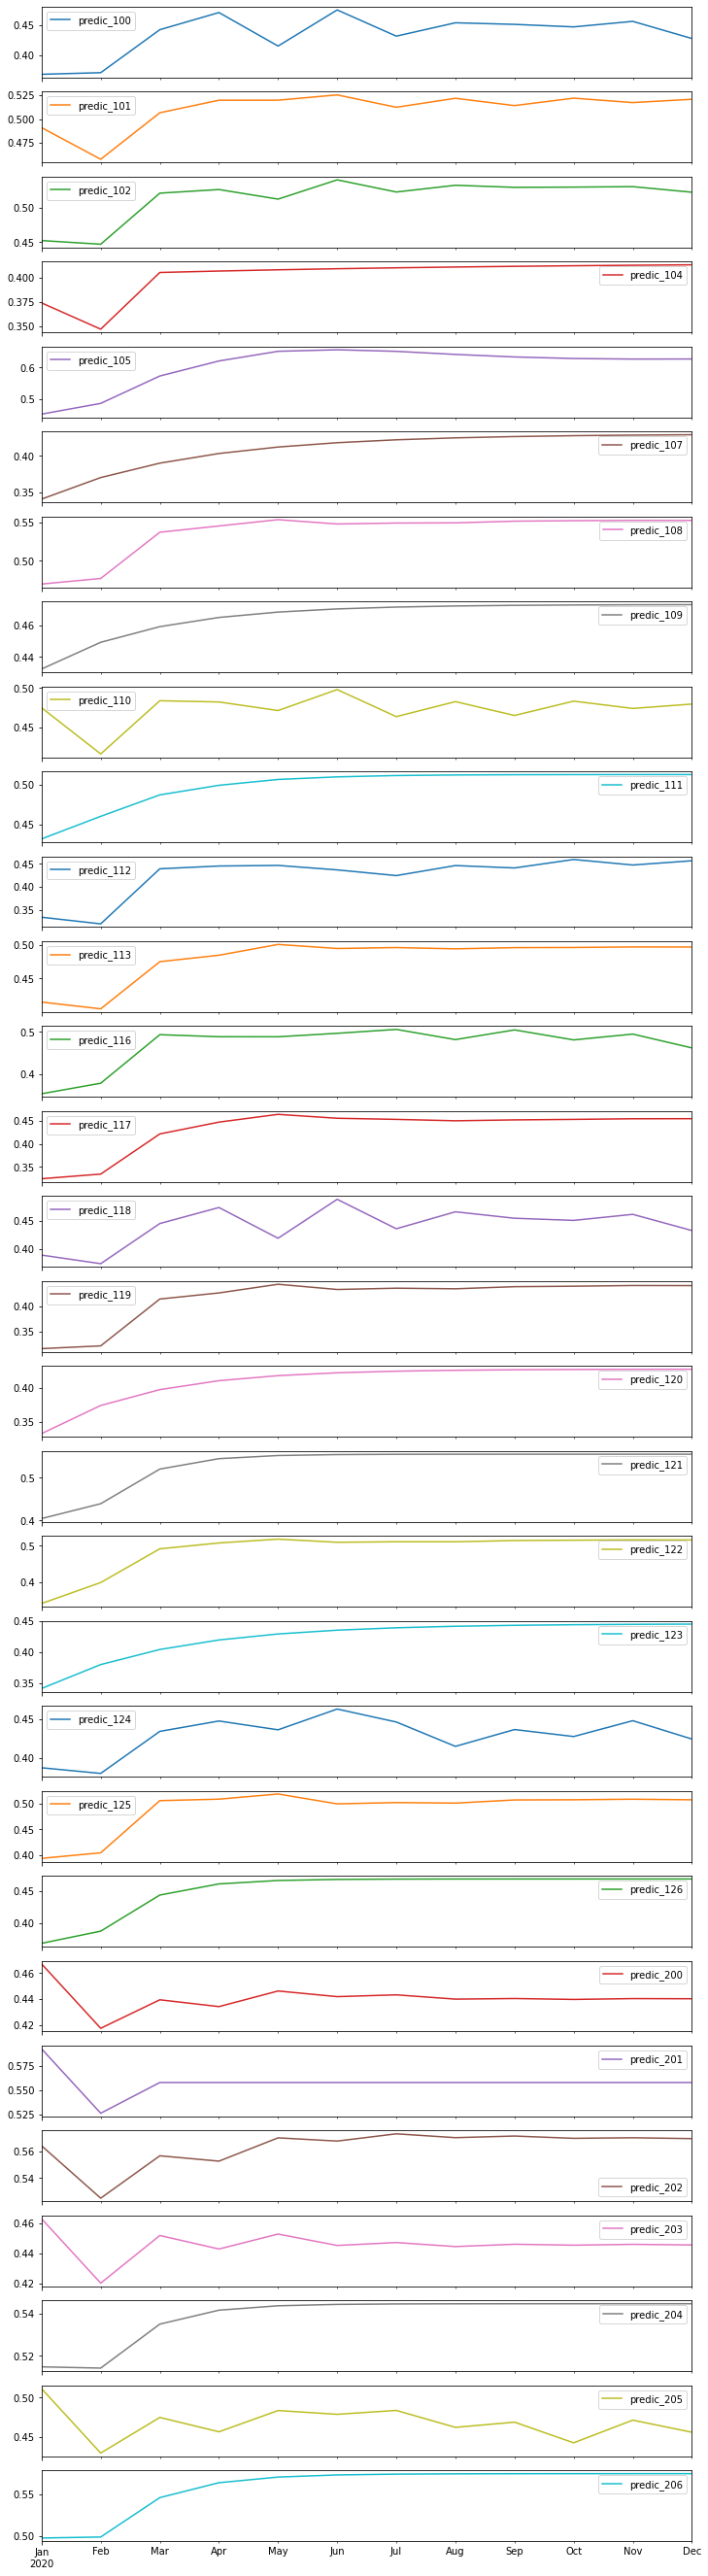

In [35]:
df_pred.plot(subplots=True,figsize=(12,48))

# ALGORITMOS DE REGRESIÓN DE APRENDIZAJE AUTOMÁTICO

In [37]:
'''Definir el horizonte de la prediccion'''
tam_ypred = 12

'''1. Cargar archivo'''
datos = cargar_datos('indices_spi3.csv')

'''2. Procesamiento de datos'''
datos_procesados = procesa_datos(datos)

'''-- Declara DF para almacenar los y_pred,
      extraer los nombres de las columnas,
      DF para almacenar los datos de la evaluacion'''
df_pred = pd.DataFrame(index = datos_procesados.tail(tam_ypred).index)
columnas = datos_procesados.columns
df_eval = pd.DataFrame(index = ['MAPE','SMAPE','MAE','RMSE','MSE'])

'''-- Normalizar datos'''
datos_normalizados = normalizar_datos(datos_procesados)

for i in range(30):
    
    '''-- Trabajar con una estación'''
    serie = datos_normalizados.iloc[:, i]
    
    '''3. Datos de entrenamiento y prueba'''
    y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)
    
    '''Definir el horizonte de predicción'''
    horizonte_prediccion = horizon_prediccion(y_test)
    
    '''4. Configurar algoritmo de regresión, valores ['LinearRegression', 'DecisionTreeRegressor','RandomForestRegressor', 'KNeighborsRegressor']'''
    predictor = config_algoritmoReg('RandomForestRegressor',  ventana = 48, estrategia = 'recursive',estimadores=30, vecinos=11)
    
    '''5. Ajuste modelo'''
    predictor = ajuste(predictor, y_train)
    
    '''6. Predicción'''
    y_pred = prediccion(predictor, horizonte_prediccion)
    
    '''7. Evaluación'''
    datos_eval = evaluacion_modelo(y_test, y_pred)
    
    '''-- Almacenar todos los y_pred y datos_eval en DFs'''
    df_pred = pd.concat([df_pred, y_pred], axis = 1)
    df_eval[i] = datos_eval

'''Cambiar el nombre de las columnas'''
df_pred.columns = ['predic_'+columna[-3:] for columna in columnas]
df_eval.columns = ['eval_'+columna[-3:] for columna in columnas]


/home/Carlos/.local/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:99: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:86: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be r

/home/Carlos/.local/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:99: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:86: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be r

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:86: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:99: FutureWarning: pandas.Int64Index is deprecated and will be 

/home/Carlos/.local/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:99: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:86: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be r

In [38]:
df_pred.to_csv('../datos/predic_spi_RT_pEst.csv', index=False)
df_eval.to_csv('../datos/eval_spi_RT_pEst.csv', index=False)

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


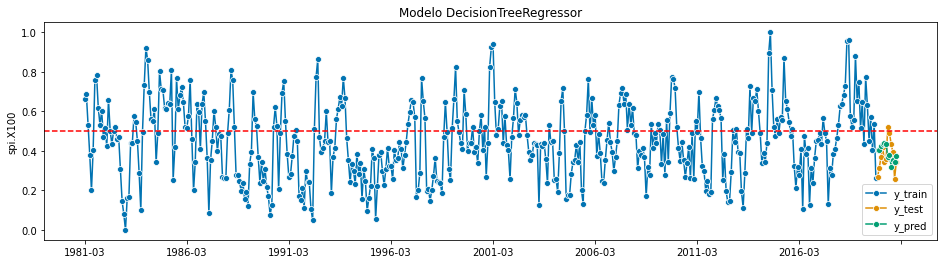

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


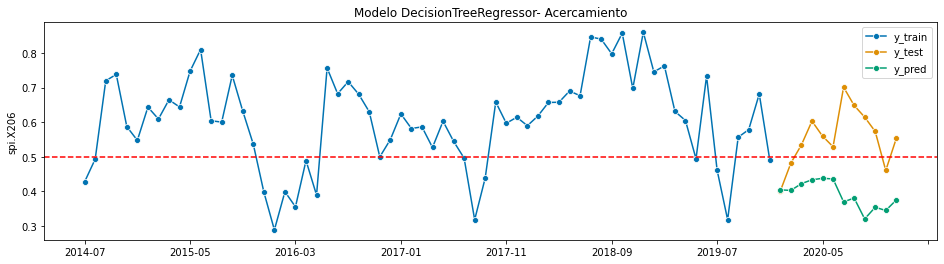

In [40]:
#La columna indica la estación de 0 a 29 para las 30 estaciones
columna = 0
train, test = dividir_datos(datos_normalizados.iloc[:, columna], tamanio = tam_ypred)
graficar_modelo(train,test,df_pred.iloc[:,columna],'Modelo DecisionTreeRegressor',0)
graficar_modelo(y_train,y_test,df_pred.iloc[:,columna], 'Modelo DecisionTreeRegressor- Acercamiento',400)

/home/Carlos/.local/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:99: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:86: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and

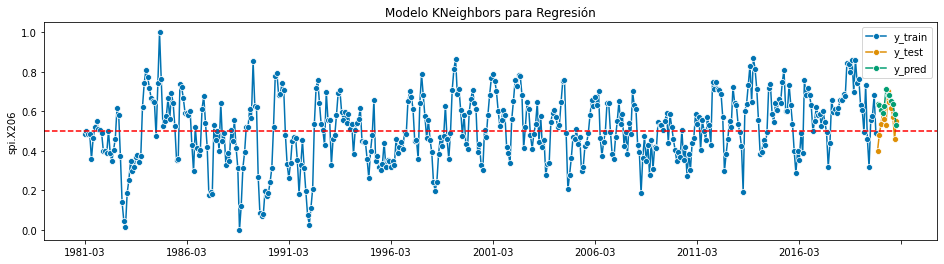

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


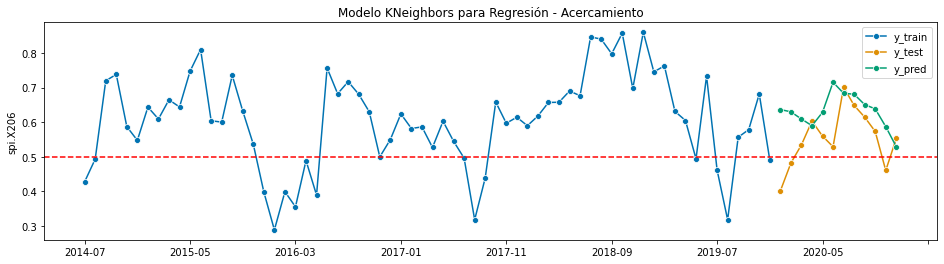

MAPE: 0.17475538631471776
SMAPE: 0.15110831046534892
MAE: 0.0856882336175855
RMSE: 0.11030837028078783
MSE: 0.012167936554003396


In [41]:
#KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
regresor = KNeighborsRegressor(n_neighbors=11)
predictor = make_reduction(regresor, strategy="recursive", window_length=48)
y_train, y_test = temporal_train_test_split(serie, fh=horizonte_prediccion)
predictor.fit(y_train)
y_pred = predictor.predict(horizonte_prediccion)
graficar_modelo(y_train,y_test,y_pred, 'Modelo KNeighbors para Regresión',0)
graficar_modelo(y_train,y_test,y_pred, 'Modelo KNeighbors para Regresión - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

In [43]:
y_test

fecha
2020-01    0.401064
2020-02    0.481692
2020-03    0.534252
2020-04    0.602893
2020-05    0.559703
2020-06    0.528825
2020-07    0.700838
2020-08    0.648194
2020-09    0.614444
2020-10    0.572967
2020-11    0.460341
2020-12    0.552805
Freq: M, Name: spi.X206, dtype: float64

/home/Carlos/.local/lib/python3.10/site-packages/sktime/forecasting/base/_fh.py:99: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  values = pd.Int64Index(values, dtype=np.int)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:86: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  assert isinstance(by, (int, np.integer, pd.Int64Index)), type(by)
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/datetime.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return pd.Int64Index([d.n for d in duration])
/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and

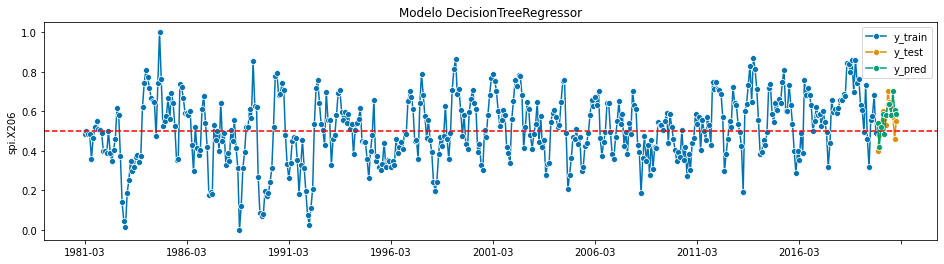

/home/Carlos/.local/lib/python3.10/site-packages/sktime/utils/validation/series.py:242: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return type(index) in (pd.Int64Index, pd.RangeIndex)


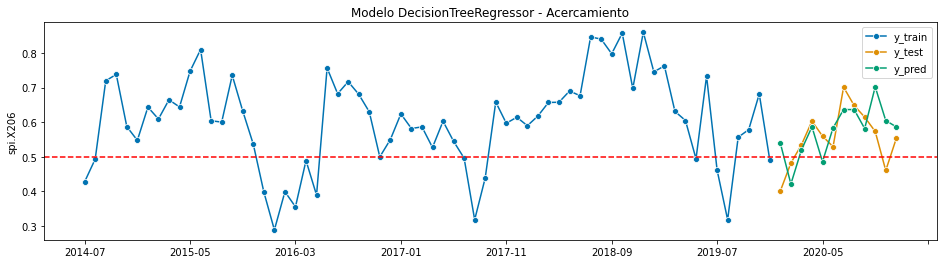

MAPE: 0.12689371116570927
SMAPE: 0.11873120732394815
MAE: 0.0645143482925494
RMSE: 0.07936708738041742
MSE: 0.006299134559250814


In [44]:
#DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sktime.forecasting.compose import make_reduction
regresor = DecisionTreeRegressor()
predictor = make_reduction(regresor, strategy="recursive", window_length=48) #swindow_length=48
predictor.fit(y_train)
y_pred = predictor.predict(horizonte_prediccion)
graficar_modelo(y_train,y_test,y_pred, 'Modelo DecisionTreeRegressor',0)
graficar_modelo(y_train,y_test,y_pred, 'Modelo DecisionTreeRegressor - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

In [47]:
y_train

fecha
1981-03    0.483292
1981-04    0.498851
1981-05    0.486767
1981-06    0.484241
1981-07    0.358138
             ...   
2019-08    0.317831
2019-09    0.556309
2019-10    0.578353
2019-11    0.681265
2019-12    0.490104
Freq: M, Name: spi.X206, Length: 466, dtype: float64

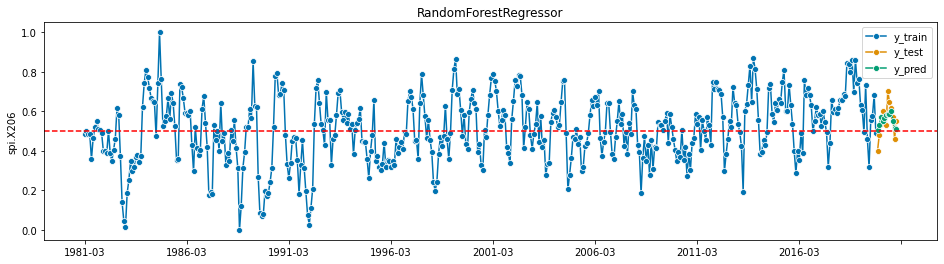

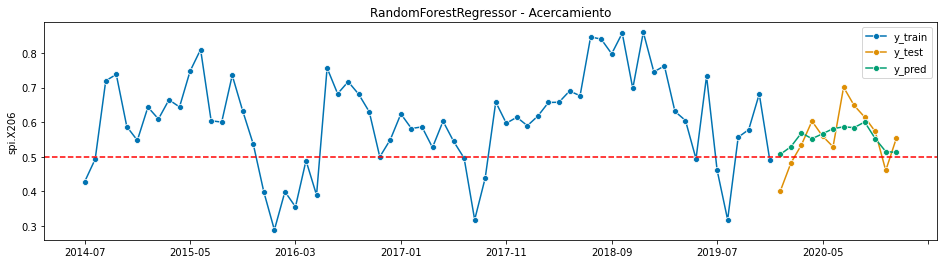

MAPE: 0.09453435508440634
SMAPE: 0.09272157125355486
MAE: 0.05046180225207903
RMSE: 0.05947851506540322
MSE: 0.003537693754385398


In [ ]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
regresor = RandomForestRegressor(n_estimators=30)
predictor = make_reduction(regresor, strategy="recursive", window_length=48) #swindow_length=48
predictor.fit(y_train)
y_pred = predictor.predict(horizonte_prediccion)
graficar_modelo(y_train,y_test,y_pred, 'RandomForestRegressor',0)
graficar_modelo(y_train,y_test,y_pred, 'RandomForestRegressor - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

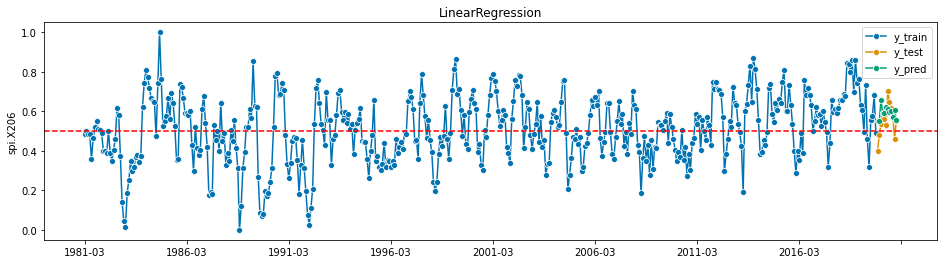

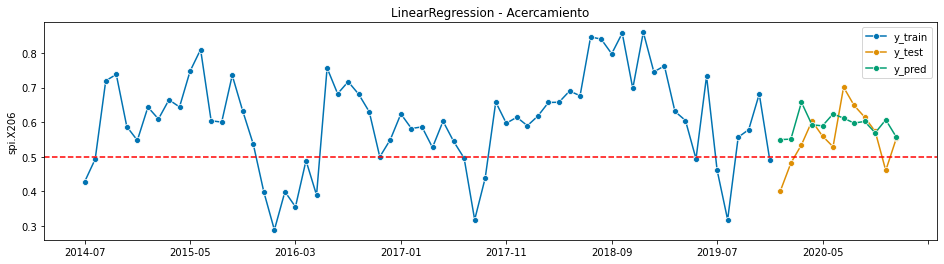

MAPE: 0.12939299235224982
SMAPE: 0.11782944638110547
MAE: 0.065249475051586
RMSE: 0.0837665947288332
MSE: 0.0070168423924645874


In [ ]:
#LinearRegression
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction
regresor = LinearRegression()
predictor = make_reduction(regresor, strategy="recursive", window_length=72) #swindow_length=72
predictor.fit(y_train)
y_pred = predictor.predict(horizonte_prediccion)
graficar_modelo(y_train,y_test,y_pred, 'LinearRegression',0)
graficar_modelo(y_train,y_test,y_pred, 'LinearRegression - Acercamiento',400)
evaluar_modelo(y_test, y_pred)

In [ ]:
#Estima los mejores parámetros de un modelo
#Utilizando  ForecastingGridSearchCV y SlidingWindowSplitte
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,
                                                SlidingWindowSplitter)
param_grid = {"window_length": [24,36,48], "estimator__n_neighbors": np.arange(1, 12)} #Original "window_length": np.arange(inf,sup)

regresor = KNeighborsRegressor()
predictor = make_reduction(regresor, strategy="recursive")
#Se define un horizonte de predicción relativo
hpred = ForecastingHorizon(np.arange(12) + 1)
cv = SlidingWindowSplitter(window_length=80, fh=hpred)  #Original window_length=60 para 144 valores
# Forecasting Grid Search
fgs = ForecastingGridSearchCV(
    predictor, cv=cv, param_grid=param_grid, strategy="refit"
)
fgs.fit(y_train)
y_pred = fgs.predict(hpred)
graficar_modelo(y_train,y_test,y_pred, 'Modelo KNeighbors para Regresión -Sliding Window',400)
evaluar_modelo(y_test, y_pred)
print('Mejores parámetros:', fgs.best_params_)